# Import Packages

In [1]:
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
import sqlite3
import seaborn as sns
from pandasql import sqldf
import numpy as np

# Project Goals

With the top 6 US studios releasing an average of 60 films per year*, Microsoft Studios™ must ensure their first releases have the best chance of box office success in order to compete with established companies.

As an initial step, ID10T Consultants were brought in to evaluate historically successful movies to understand the common characteristics shared by Box Office Hits. 


# Data

01    |    Financial Information - The Numbers Movie Budget Data

02    |    Genre Information - IMDB Movie Database

03    |   Actor / Director Information - IMDB Movie Database

04    |    Release Date Information - IMDB Movie Database

05    |    Critic Review Data - IMDB Movie Database

# Methods

Domestic Gross Revenue: Useful to understand interests of US viewers, but difficult to understand global appeal.

Global  Gross Revenue: Better metric than domestic gross, and widely used by the general public to understand success at the box office. However, not all box office hits are profitable.

Profitability: Profitability is a useful tool to understand the characteristics of movies that provided a strong return, but inflation negatively impacts the weighting of old vs new films by profits.

Return On Investment (ROI): With a percentage-based metric, we can standardize profit across all films to understand what leads to a box office hit.


__ROI will be the primary indicator used for box office success__ 


# Charlie Section - ID Best Genres to use Based on Historical Successful Movies

### Review Data Available for Movie Genre/Box Office Success

It looks like first going into the IM.DB database is a good way to see what movies are in our dataset

In [2]:
conn = sqlite3.connect('./Data/im.db')

Looking at how to access all tables/table names

In [3]:
pd.read_sql('''
SELECT
    *
FROM
    sqlite_master

''',conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


After looking at the ERD, it looks like financial data is going to have to come from the movie budgets csv. For our metric of box office success, we want to use profit and return on investment (ROI) to best choose our type of movie.

We could potentially use critic score from the ratings data table in IMDB if we wanted our studio to be known for producing critically acclaimed films that could win an award, but as a new studio, our execs are likely more worried about financials until their budget is large enough to take risks.

In [4]:
tnmovie = pd.read_csv('./Data/tn.movie_budgets.csv', parse_dates = ['release_date'])

In [5]:
tnmovie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


### Cleaning the movie budget csv to use numerical data

Additionally, addding a profit and a percent return (ROI) column

In [6]:
tnmovie['worldwide_gross'] = tnmovie['worldwide_gross'].str.replace("\$|,|\.", '', regex = True).astype('int64')

tnmovie['domestic_gross'] = tnmovie['domestic_gross'].str.replace("\$|,|\.", '', regex = True).astype('int64')

tnmovie['production_budget'] = tnmovie['production_budget'].str.replace("\$|,|\.", '', regex = True).astype('int64')

tnmovie['profit'] = tnmovie['worldwide_gross'] - tnmovie['production_budget']

tnmovie['perc_return'] = (tnmovie['profit'] / tnmovie['production_budget']) * 100

In [7]:
tnmovie.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,perc_return
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,553.257713
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,154.667286
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-57.210757
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,324.384139
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,315.369636


In [8]:
tnmovie = tnmovie.sort_values(by='profit',
                   ascending=False)

In [9]:
tnmovie.shape

(5782, 8)

### Creating a Movie Basics dataframe from the IM.DB Database to grab movie genres

In [10]:
moviebasics = pd.read_sql('''
SELECT
    primary_title,
    genres
FROM
    movie_basics
WHERE
    primary_title = original_title

''',conn)

In [11]:
moviebasics.head()

,primary_title,genres
0,Sunghursh,"Action,Crime,Drama"
1,The Other Side of the Wind,Drama
2,Sabse Bada Sukh,"Comedy,Drama"
3,A Thin Life,Comedy
4,Bigfoot,"Horror,Thriller"


### Creating a grouped dataframe to pull in genres w/ budget

#### Creating a new clean dataframe with just film title, genres,production_budget, worldwide_gross, and profit

First, creating a new grouped dataframe with duplicate movies to not lose any genres,
Then removing rows with null values in genres

In [12]:
genres = pd.merge(moviebasics,
                  tnmovie,
                  left_on='primary_title',
                  right_on='movie')

genres.dropna(subset=['genres'],
             inplace=True)

Now, updating the genres dataframe into a new, smaller dataframe with only pertinent columns

In [13]:
genres_clean = genres.filter(['primary_title', 'genres', 'production_budget', 'worldwide_gross', 'profit', 'perc_return'], axis=1)


In [14]:
genres_clean.shape

(3381, 6)

Quick check to see which movies have a large ROI

In [15]:
genres_clean.sort_values(by='perc_return',
                        ascending=False,
                        inplace=True)

It appears that the top ROI movies didn't necessarily have large budgets, leading to an outsized ROI. 

Some of these movies may have such a large global gross due to cult status or nostalgia (Cinderella, Rocky, Bambi). We want a fan following, but we don't want to risk selection of genre that may not be successful (at large).

Additionally, the data frame has duplicate rows (all values same) - we can drop these duplicates as it won't impact understanding the financials or the genre type.

Next step cleans for complete duplicates, and filters down to only include movies with a global gross over 152,962,083 (the revenue of the 1000th top grossing movie).

This way, our dataframe will suggest the genre to use for a movie if the studio wants to produce a top 1000 movie (by worldwide gross, the biggest metric used by the public) and what the genre should be to get a strong ROI.

By filtering the genres_clean dataframe to only inlcude movies that have grossed in the top 100 worldwide, our dataframe has shrunk to only 561 records

### With a clean dataframe of movies and genres, create a new dataframe with Booleans for whether the movie has a certain genre

First create a new dataframe of just name, perc_return, and genre to use for analysis

In [16]:
genres_final = genres_clean.filter(['primary_title', 'genres', 'perc_return'], axis=1)

Next, use a lambda to concatenate the genres by title so we only have one record per title

In [17]:
genres_final['genres'] = genres_clean.groupby(['primary_title'])['genres'].transform(lambda x : ','.join(x))
  
# drop duplicate data
genres_final = genres_final.drop_duplicates(keep='first')   

In [18]:
genres_final.head(15)

,primary_title,genres,perc_return
2306,The Gallows,"Horror,Mystery,Thriller",41556.474000
2540,Bambi,"Biography,Documentary",31135.431235
2789,Night of the Living Dead,"Horror,Horror",26292.161404
2685,Rocky,"Action,Comedy,Drama,Action,Drama,Romance",22400.000000
1065,Halloween,"Horror,Thriller,Horror,Thriller,Horror,Thriller",21438.461538
3386,Snow White and the Seven Dwarfs,"Animation,Family,Comedy,Drama,Fantasy",12327.788038
1149,The Devil Inside,Horror,10075.949000
3006,The Birth of a Nation,"Biography,Drama,History,Biography,Drama,History",9900.000000
2512,Graduation Day,Thriller,9457.600000
214,Cinderella,"Musical,Comedy,Fantasy,Drama,Family,Fantasy,Fa...",8989.359138


In [19]:
genres_final.shape

(2263, 3)

After running the last drop duplicates, our list of movies over the 1000 gross mark is 444 movies total.

Now, create a list of unique genres to use as the columns to run a bolean dataframe

In [20]:
genres_list = list(genres_final['genres'].str.split(','))

In [21]:
type(genres_list)

list

Updating a final list that only includes unique genres

In [22]:
genre_list_final = []    

for i in genres_list:
    for genre in i:
        if genre in genre_list_final:
            continue
        else:
            genre_list_final.append(genre)

In [23]:
len(genre_list_final)

23

### Create new columns in the dataframe for unique genres, then run a numpy where to mark the column as 1 for true, 0 for false if the movie is in that genre

In [24]:
for genre in genre_list_final:
   genres_final[genre] = 0

In [25]:
genres_final.head()

,primary_title,genres,perc_return,Horror,Mystery,Thriller,Biography,Documentary,Action,Comedy,...,Musical,Music,War,Adventure,Sport,Crime,Sci-Fi,Western,News,Reality-TV
2306,The Gallows,"Horror,Mystery,Thriller",41556.474000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2540,Bambi,"Biography,Documentary",31135.431235,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2789,Night of the Living Dead,"Horror,Horror",26292.161404,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2685,Rocky,"Action,Comedy,Drama,Action,Drama,Romance",22400.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1065,Halloween,"Horror,Thriller,Horror,Thriller,Horror,Thriller",21438.461538,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Building a for loop based on the unique genre list to update each genre column with 0 or 1

In [26]:
for genre in genre_list_final:
    genres_final[genre] = np.where(genres_final.genres.str.contains(genre),1,0)

In [27]:
genres_final

,primary_title,genres,perc_return,Horror,Mystery,Thriller,Biography,Documentary,Action,Comedy,...,Musical,Music,War,Adventure,Sport,Crime,Sci-Fi,Western,News,Reality-TV
2306,The Gallows,"Horror,Mystery,Thriller",41556.474000,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2540,Bambi,"Biography,Documentary",31135.431235,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2789,Night of the Living Dead,"Horror,Horror",26292.161404,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2685,Rocky,"Action,Comedy,Drama,Action,Drama,Romance",22400.000000,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1065,Halloween,"Horror,Thriller,Horror,Thriller,Horror,Thriller",21438.461538,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,Aztec Warrior,"Action,Comedy",-100.000000,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2263,The Maid's Room,Thriller,-100.000000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2268,Forsaken,"Action,Drama,Western,Adventure,Drama,Horror,Th...",-100.000000,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3204,Bright,"Action,Crime,Fantasy",-100.000000,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


### With the Boolean columns, Create a new dataframe that stores the count of movies with that genre, and the average ROI for that genre

First, create dictionary that stores the count and average ROI in a dictionary under the key with the name of the given genre

In [28]:
genre_dict = {}

for genre in genre_list_final:
    genre_dict[genre] = {'genre_count':genres_final[genre].sum().astype(int),
                         'genre_avg_roi':np.array(genres_final.groupby(genre).perc_return.mean())[1]}

In [29]:
type(genre_dict['Biography']['genre_avg_roi'])

numpy.float64

Confirm dictionary worked

In [30]:
genre_dict

{'Horror': {'genre_count': 359, 'genre_avg_roi': 715.442614832116},
 'Mystery': {'genre_count': 216, 'genre_avg_roi': 605.3195479331259},
 'Thriller': {'genre_count': 482, 'genre_avg_roi': 438.80175206268075},
 'Biography': {'genre_count': 230, 'genre_avg_roi': 401.15022199228173},
 'Documentary': {'genre_count': 344, 'genre_avg_roi': 278.8158688486792},
 'Action': {'genre_count': 626, 'genre_avg_roi': 211.20039452685313},
 'Comedy': {'genre_count': 727, 'genre_avg_roi': 281.3488120142727},
 'Drama': {'genre_count': 1222, 'genre_avg_roi': 243.19871920026168},
 'Romance': {'genre_count': 304, 'genre_avg_roi': 290.5038460962458},
 'Animation': {'genre_count': 128, 'genre_avg_roi': 448.6831573006716},
 'Family': {'genre_count': 175, 'genre_avg_roi': 409.55690131189965},
 'Fantasy': {'genre_count': 176, 'genre_avg_roi': 376.6501954577214},
 'History': {'genre_count': 80, 'genre_avg_roi': 334.61609840723816},
 'Musical': {'genre_count': 29, 'genre_avg_roi': 677.130731841542},
 'Music': {'ge

Make a dataframe of the 444 movies that have a worldwide gross that would place them in the top 1000

In [31]:
top_films = pd.DataFrame.from_dict(genre_dict)

In [32]:
top_films.head()

,Horror,Mystery,Thriller,Biography,Documentary,Action,Comedy,Drama,Romance,Animation,...,Musical,Music,War,Adventure,Sport,Crime,Sci-Fi,Western,News,Reality-TV
genre_count,359.000000,216.000000,482.000000,230.000000,344.000000,626.000000,727.000000,1222.000000,304.000000,128.000000,...,29.000000,104.000000,41.000000,461.000000,69.000000,353.000000,209.000000,24.000000,6.000000,1.0
genre_avg_roi,715.442615,605.319548,438.801752,401.150222,278.815869,211.200395,281.348812,243.198719,290.503846,448.683157,...,677.130732,336.414598,336.123309,210.195004,254.567435,130.817968,202.556663,38.949819,24.184002,-100.0


Transpose the dataframe to get the genre names as a column of genres, vs as the columns

In [33]:
top_films = top_films.transpose()

In [34]:
top_films.head()

,genre_count,genre_avg_roi
Horror,359.0,715.442615
Mystery,216.0,605.319548
Thriller,482.0,438.801752
Biography,230.0,401.150222
Documentary,344.0,278.815869


In [35]:
top_genres = top_films.sort_values(by='genre_count',
                   ascending=False,
                   inplace=False)

reset the index so the genres. can be used as categories for a bar chart

In [36]:
top_genres.reset_index(inplace=True)

In [37]:
top_genres.rename(columns={'index': 'genre'}, inplace=True)

In [38]:
top_genres

,genre,genre_count,genre_avg_roi
0,Drama,1222.0,243.198719
1,Comedy,727.0,281.348812
2,Action,626.0,211.200395
3,Thriller,482.0,438.801752
4,Adventure,461.0,210.195004
5,Horror,359.0,715.442615
6,Crime,353.0,130.817968
7,Documentary,344.0,278.815869
8,Romance,304.0,290.503846
9,Biography,230.0,401.150222


### Visualization

In [39]:
top_genres = top_genres.sort_values(by='genre_avg_roi',
                   ascending=False,
                   inplace=False)

Text(0, 0.5, '% ROI')

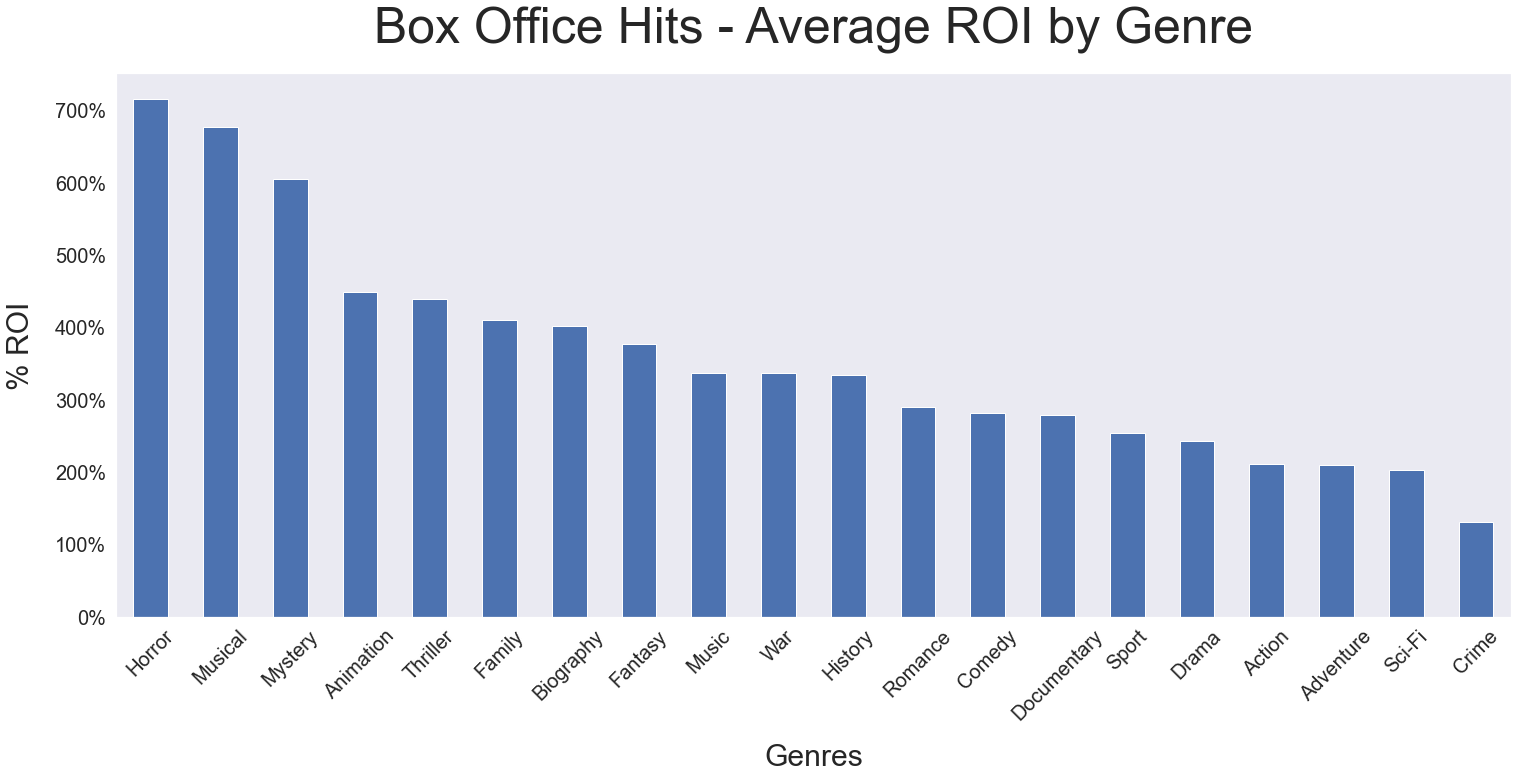

In [40]:
sns.set(style="white")

sns.color_palette("rocket")

sns.set(rc = {'figure.figsize':(25,10)})

#create stacked bar chart
plot2 = top_genres.head(20).set_index('genre').plot(kind='bar', y='genre_avg_roi', stacked=False, legend=False)

#add overall title
plt.title('Box Office Hits - Average ROI by Genre', fontsize=50, pad=30)
plt.grid(False)

#update y axis from scientific notation
plot2.yaxis.set_major_formatter(mtick.PercentFormatter())

#add axis titles
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Genres', fontsize=30, labelpad=20)
plt.ylabel('% ROI', fontsize=30,  labelpad=20)

### Findings

If the studio wanted to produce a movie in a genre that would lead to the best ROI. As a new studio, movies that can create a strong return may be more important to demonstrate the studio's viability to Mr. Gates.

If so, movies that don't require a large budget, like a horror, mystery, or musical may be the better option.

With these visualizations, it's important to note that they all had massive appeal, as they come from a dataset of films that did very well, so no matter the choice of genre, it's important to make a good film the public will enjoy. 

How you select your actors and your directors will play a very big role in how any movie in any genre will perform.

# Alvaro Section - ID the best actors and directors to use for your films based on the historical profit from their films

# Directors SQL

Use SQL query to join tables by primary and foreign keys. This new comprehensive dataframe contains indentifying data regarding directors.

In [41]:
directors_df = pd.read_sql('''
SELECT
    category,
    pr.person_id,
    pr.movie_id,
    primary_name,
    primary_title
FROM
    principals as pr
INNER JOIN
    persons as p using(person_id)
INNER JOIN
    movie_basics as mb using(movie_id)
WHERE
    category = 'director'
''',conn)

directors_df

,category,person_id,movie_id,primary_name,primary_title
0,director,nm0398271,tt0111414,Frank Howson,A Thin Life
1,director,nm0362736,tt0323808,Robin Hardy,The Wicker Tree
2,director,nm1145057,tt0417610,Alejandro Chomski,Asleep in the Sun
3,director,nm0707738,tt0469152,Alyssa R. Bennett,Smoking/Non-Smoking
4,director,nm0776090,tt0473032,J. Neil Schulman,Escape from Heaven
...,...,...,...,...,...
146388,director,nm9728620,tt9679036,Julia Beney,"A Girl, a Boy, a Penny and a Very, Very, Very ..."
146389,director,nm10436661,tt9681728,Alexander Zolotukhin,A Russian Youth
146390,director,nm9652770,tt9689618,Xavi Herrero,Moonface. A woman in the war.
146391,director,nm10439725,tt9689618,Xavi Herrero,Moonface. A woman in the war.


# Directors dataframe merge

Merge the directors and tnmovie dataframes on 'primary_title' and 'movie'

In [42]:
directors_df = pd.merge(directors_df,
                  tnmovie,
                  left_on='primary_title',
                  right_on='movie')

directors_df 

,category,person_id,movie_id,primary_name,primary_title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,perc_return
0,director,nm0001053,tt0475290,Ethan Coen,"Hail, Caesar!",22,2016-02-05,"Hail, Caesar!",22000000,30080225,64160680,42160680,191.639455
1,director,nm0001054,tt0475290,Joel Coen,"Hail, Caesar!",22,2016-02-05,"Hail, Caesar!",22000000,30080225,64160680,42160680,191.639455
2,director,nm10678795,tt10300704,Anbarasan,Walter,96,2015-03-13,Walter,700000,0,0,-700000,-100.000000
3,director,nm1457361,tt2016335,Anna Mastro,Walter,96,2015-03-13,Walter,700000,0,0,-700000,-100.000000
4,director,nm6315709,tt3558672,Daniela Imhoff,Walter,96,2015-03-13,Walter,700000,0,0,-700000,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3864,director,nm0619110,tt7961060,Tatsuya Nagamine,Dragon Ball Super: Broly,36,2019-01-16,Dragon Ball Super: Broly,8500000,30376755,122747755,114247755,1344.091235
3865,director,nm3258280,tt6962340,Anand Vrs Tomar,The Touch,10,2004-03-31,The Touch,20000000,0,5918742,-14081258,-70.406290
3866,director,nm4991904,tt9805168,Janchivdorj Sengedorj,Traitor,25,2008-08-27,Traitor,22000000,23530831,27882226,5882226,26.737391
3867,director,nm9457387,tt7694546,Zefei Liu,Beowulf,88,2007-11-16,Beowulf,150000000,82280579,195080579,45080579,30.053719


# Directors by Average Profit

Count the how many times a name appears in the 'primary_name' column and sort it. These directors have all directed at least 5 films.

In [43]:
directors_5_films = directors_df.value_counts('primary_name').head(28)

directors_5_films

primary_name
Tim Story             9
David Gordon Green    8
Steven Spielberg      8
Steven Soderbergh     7
Ridley Scott          7
Clint Eastwood        6
Tim Burton            6
Peter Berg            6
Jaume Collet-Serra    6
Denis Villeneuve      6
Jon M. Chu            6
Guillermo del Toro    5
Ron Howard            5
Robert Rodriguez      5
David O. Russell      5
Roland Emmerich       5
Francis Lawrence      5
Zack Snyder           5
Simon West            5
Nicholas Stoller      5
Brad Peyton           5
Paul W.S. Anderson    5
Paul Feig             5
Jonathan Levine       5
Antoine Fuqua         5
Danny Boyle           5
David Ayer            5
M. Night Shyamalan    5
dtype: int64

Make a list of director names using index.

In [44]:
directors_5_films = list(directors_5_films.index)

directors_5_films

['Tim Story',
 'David Gordon Green',
 'Steven Spielberg',
 'Steven Soderbergh',
 'Ridley Scott',
 'Clint Eastwood',
 'Tim Burton',
 'Peter Berg',
 'Jaume Collet-Serra',
 'Denis Villeneuve',
 'Jon M. Chu',
 'Guillermo del Toro',
 'Ron Howard',
 'Robert Rodriguez',
 'David O. Russell',
 'Roland Emmerich',
 'Francis Lawrence',
 'Zack Snyder',
 'Simon West',
 'Nicholas Stoller',
 'Brad Peyton',
 'Paul W.S. Anderson',
 'Paul Feig',
 'Jonathan Levine',
 'Antoine Fuqua',
 'Danny Boyle',
 'David Ayer',
 'M. Night Shyamalan']

Iterate through the directors_5_films. Next, locate the rows and columns where the 'primary_name' is equal to the director's name. Then, append the average profit for each movie the director directed in to a new list.

In [45]:
avg_dir = []

for director in directors_5_films:
    directors_filtered = directors_df.loc[directors_df['primary_name'] == director]
    avg_dir.append(directors_filtered.profit.mean())
    
avg_dir[:5]

[48457857.44444445,
 42364834.5,
 164754974.375,
 45581726.85714286,
 176967321.2857143]

Create a dataframe using zip with the directors_5_films and average profit lists

In [46]:
directing_df = pd.DataFrame(list(zip(directors_5_films, avg_dir)),
               columns =['director_name', 'average_profit'])

In [47]:
directing_df.head()

,director_name,average_profit
0,Tim Story,4.845786e+07
1,David Gordon Green,4.236483e+07
2,Steven Spielberg,1.647550e+08
3,Steven Soderbergh,4.558173e+07
4,Ridley Scott,1.769673e+08


Sort the dataframe by 'average_profit'

In [48]:
directing_df.sort_values(by='average_profit', inplace=True, ascending=False)

# Directors by Average Profit - Data Visualization

Create a barh using seaborn with the average profit for each movie the director directed on the x-axis and the director name column on the y-axis. Change x-axis units from scientific notation to easily readable numbers.

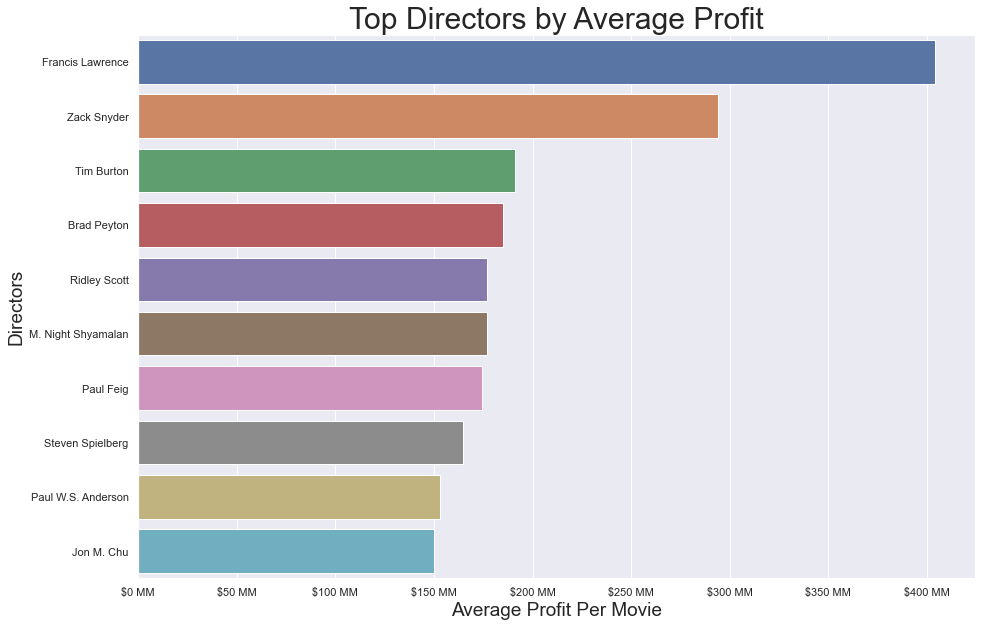

In [49]:
sns.set(style="white")

sns.color_palette("rocket")

sns.set(rc = {'figure.figsize':(15,10)})

g = sns.barplot(x='average_profit', y='director_name', data=directing_df.head(10))

plt.title('Top Directors by Average Profit', fontsize=30)
plt.xlabel('Average Profit Per Movie', fontsize=19)
plt.ylabel('Directors', fontsize=19)

ticks_loc = g.get_xticks().tolist()
g.xaxis.set_major_locator(mtick.FixedLocator(ticks_loc))
label_format = '{:,.0f}'
g.set_xticklabels([label_format.format(x) for x in ticks_loc])

xlabels = ['${:,.0f}'.format(x) + ' MM' for x in g.get_xticks()/1000000]
g.set_xticklabels(xlabels);

# Findings

Directors draw in audiences! Steven Spielbergs, Tim Burtons, and Ridley Scotts 
create universes that pull over $150 million in box office. These directors have unqiue, 
beloved fimlamking styles. And their fans come out in droves to experience them in theaters. 
Sometimes multiple times. With one these visionaries at the helm, Microsoft may likley produce 
an instant classic and a blockbuster hit at the same time.

# Actors SQL

Use SQL query to join tables by primary and foreign keys. This new comprehensive dataframe contains indentifying data regarding actors.

In [50]:
actors = pd.read_sql('''
SELECT
    category,
    pr.person_id,
    pr.movie_id,
    primary_name,
    primary_title
FROM
    principals as pr
INNER JOIN
    persons as p using(person_id)
INNER JOIN
    movie_basics as mb using(movie_id)
WHERE
    category = 'actor' 
    or
    category = 'actress'
''',conn)

actors

,category,person_id,movie_id,primary_name,primary_title
0,actor,nm0246005,tt0111414,Tommy Dysart,A Thin Life
1,actress,nm3579312,tt0323808,Brittania Nicol,The Wicker Tree
2,actor,nm2694680,tt0323808,Henry Garrett,The Wicker Tree
3,actor,nm0574615,tt0323808,Graham McTavish,The Wicker Tree
4,actress,nm0502652,tt0323808,Jacqueline Leonard,The Wicker Tree
...,...,...,...,...,...
402680,actor,nm10397910,tt9681728,Danil Tyabin,A Russian Youth
402681,actor,nm10439726,tt9689618,Christian Lacroix,Moonface. A woman in the war.
402682,actor,nm10439727,tt9689618,Christine Spengler,Moonface. A woman in the war.
402683,actor,nm10439724,tt9689618,Phillippe Warner,Moonface. A woman in the war.


# Actors Dataframe Merge

Merge the actors and tnmovie dataframes on 'primary_title' and 'movie'

In [51]:
actors_df = pd.merge(actors,
                  tnmovie,
                  left_on='primary_title',
                  right_on='movie')

actors_df

,category,person_id,movie_id,primary_name,primary_title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,perc_return
0,actor,nm0000982,tt0475290,Josh Brolin,"Hail, Caesar!",22,2016-02-05,"Hail, Caesar!",22000000,30080225,64160680,42160680,191.639455
1,actor,nm0000123,tt0475290,George Clooney,"Hail, Caesar!",22,2016-02-05,"Hail, Caesar!",22000000,30080225,64160680,42160680,191.639455
2,actor,nm2403277,tt0475290,Alden Ehrenreich,"Hail, Caesar!",22,2016-02-05,"Hail, Caesar!",22000000,30080225,64160680,42160680,191.639455
3,actor,nm0000146,tt0475290,Ralph Fiennes,"Hail, Caesar!",22,2016-02-05,"Hail, Caesar!",22000000,30080225,64160680,42160680,191.639455
4,actor,nm0006763,tt10300704,Jackie Shroff,Walter,96,2015-03-13,Walter,700000,0,0,-700000,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13362,actor,nm10487076,tt9805168,E. Iderbold,Traitor,25,2008-08-27,Traitor,22000000,23530831,27882226,5882226,26.737391
13363,actor,nm10480867,tt9805168,N. Yalalt,Traitor,25,2008-08-27,Traitor,22000000,23530831,27882226,5882226,26.737391
13364,actor,nm10487077,tt9805168,A. Önörjargal,Traitor,25,2008-08-27,Traitor,22000000,23530831,27882226,5882226,26.737391
13365,actor,nm9457389,tt7694546,Dongchao Tai,Beowulf,88,2007-11-16,Beowulf,150000000,82280579,195080579,45080579,30.053719


# Actors by Average Profit

Count the how many times a name appears in the 'primary_name' column and sort it. These actors have all starred in at least 15 films.

In [52]:
actors_15_films = actors_df.value_counts('primary_name').head(18)

actors_15_films

primary_name
Mark Wahlberg          19
Dwayne Johnson         19
Robert De Niro         18
Liam Neeson            18
Steve Carell           17
Channing Tatum         17
Joel Edgerton          17
Kevin Hart             16
Johnny Depp            16
Matthew McConaughey    16
Nicolas Cage           15
Michael Fassbender     15
Anna Kendrick          15
Tom Hardy              15
Jennifer Lawrence      15
Owen Wilson            15
Nicole Kidman          15
Chris Hemsworth        15
dtype: int64

Make a list of actor names using index.

In [53]:
actors_15_films = list(actors_15_films.index)

actors_15_films

['Mark Wahlberg',
 'Dwayne Johnson',
 'Robert De Niro',
 'Liam Neeson',
 'Steve Carell',
 'Channing Tatum',
 'Joel Edgerton',
 'Kevin Hart',
 'Johnny Depp',
 'Matthew McConaughey',
 'Nicolas Cage',
 'Michael Fassbender',
 'Anna Kendrick',
 'Tom Hardy',
 'Jennifer Lawrence',
 'Owen Wilson',
 'Nicole Kidman',
 'Chris Hemsworth']

Iterate through the actors_15_films list. Next, locate the rows and columns where the 'primary_name' is equal to the actors's name. Then, append the average profit for each movie the actor appeared in to a new list.

In [54]:
avg_actor = []

for actor in actors_15_films:
    actors_filtered = actors_df.loc[actors_df['primary_name'] == actor]
    avg_actor.append(actors_filtered.profit.mean())
    
avg_actor[:10]

[137891808.0526316,
 329997202.68421054,
 53687091.777777776,
 104063632.1111111,
 166251075.47058824,
 107753628.64705883,
 29842502.94117647,
 166645292.0625,
 184810854.8125,
 103858957.625]

Create a dataframe using zip with the actors_15_films and average profit lists

In [55]:
acting_df = pd.DataFrame(list(zip(actors_15_films, avg_actor)),
               columns =['actor_name', 'average_profit'])

Sort the dataframe by 'average_profit'

In [56]:
acting_df.sort_values(by='average_profit', inplace=True, ascending=False)

# Actors by Average Profit - Data Visualization


Create a barh using seaborn with the average profit column on the x-axis and the actors name column on the y-axis.

Change x-axis units from scientific notation to easily readable numbers.

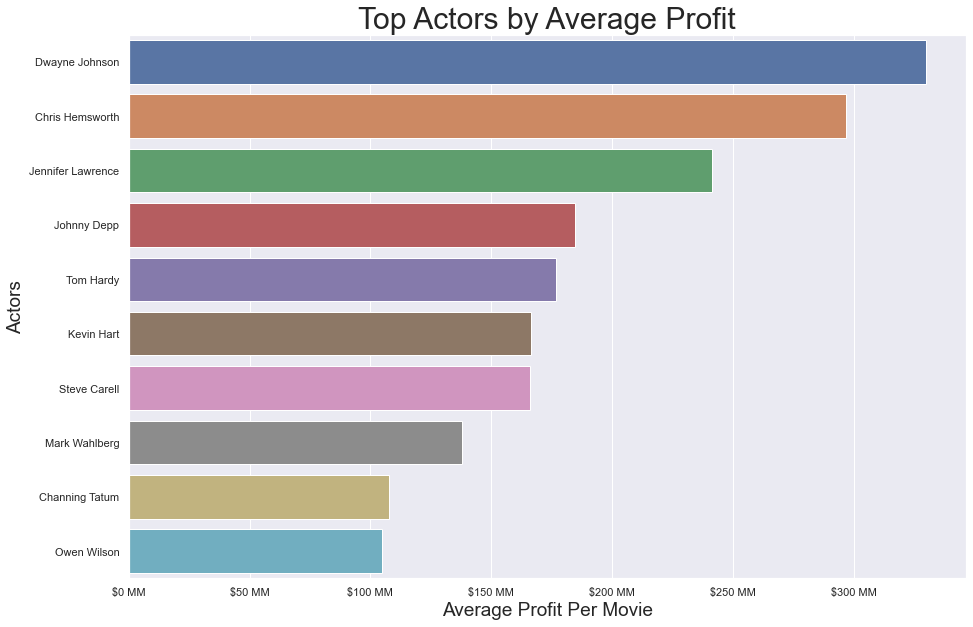

In [57]:
sns.set(style="white")

sns.color_palette("rocket")

sns.set(rc = {'figure.figsize':(15,10)})

g = sns.barplot(x='average_profit', y='actor_name', data=acting_df.head(10))

plt.title('Top Actors by Average Profit', fontsize=30)
plt.xlabel('Average Profit Per Movie', fontsize=19)
plt.ylabel('Actors', fontsize=19)

plt.ticklabel_format(axis='x', style='plain')
ticks_loc = g.get_xticks().tolist()
g.xaxis.set_major_locator(mtick.FixedLocator(ticks_loc))
label_format = '{:,.0f}'
g.set_xticklabels([label_format.format(x) for x in ticks_loc])

xlabels = ['${:,.0f}'.format(x) + ' MM' for x in g.get_xticks()/1000000]
g.set_xticklabels(xlabels);

# Findings

Movie star appeal is a major box office draw! Actors like Dwayne Johnson, Jennifer Lawrence, and Kevin Hart not only makes us laugh and cry, they also inspire us. These actors average over $150 million per film because they have an army of die-hard fans always ready to invade the next midnight premiere. Casting one these stars in a Microsoft movie, may likley drive high box office sales.

# Next Steps

We would like to explore the relationship between directors and actors and genres. Entertainment goliaths like Marvel and DC are exclusively held but Microsoft could hire an acclaimed director and produce their own rival franchises based on widely consumed source materials with an already rabid fan base. For example, someone like Denis Villeneuve (directed Dune) may be a great fit for this role. Establishing such a foothold could boost box office sales, grow viewership, and bolster the prestige of the fledgling studio.

# Jordan's Section - Understanding How Release Date and Critic Ratings Impact Box Office Success

### Formatting Release Date to M/D format

In [58]:
tnmovie['release_date_month'] = tnmovie['release_date'].dt.strftime('%m/%d')

### Creating Release_Week, Month and Year Columns

In [59]:
tnmovie['release_week'] = tnmovie['release_date'].dt.strftime('%U')

In [60]:
tnmovie['release_month'] = tnmovie['release_date'].dt.strftime('%m')

In [61]:
tnmovie['release_year'] = tnmovie['release_date'].dt.strftime('%Y')

In [62]:
tnmovie.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,perc_return,release_date_month,release_week,release_month,release_year
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,553.257713,12/18,50,12,2009
42,43,1997-12-19,Titanic,200000000,659363944,2208208395,2008208395,1004.104198,12/19,50,12,1997
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,582.711400,04/27,16,04,2018
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220,571.016739,12/18,50,12,2015
33,34,2015-06-12,Jurassic World,215000000,652270625,1648854864,1433854864,666.909239,06/12,23,06,2015


In [63]:
tnmovie = tnmovie.sort_values(by='release_week',
                   )

In [64]:
tnmovie.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,perc_return,release_date_month,release_week,release_month,release_year
5455,56,1991-01-01,Johnny Suede,500000,55000,55000,-445000,-89.000000,01/01,00,01,1991
5527,28,1980-01-01,Maniac,350000,10000000,10000000,9650000,2757.142857,01/01,00,01,1980
4819,20,1971-01-01,Escape from the Planet of the Apes,2500000,12300000,12300000,9800000,392.000000,01/01,00,01,1971
2750,51,1964-01-01,The Fall of the Roman Empire,19000000,4750000,4750000,-14250000,-75.000000,01/01,00,01,1964
3544,45,2018-01-05,Insidious: The Last Key,10000000,67745330,167885588,157885588,1578.855880,01/05,00,01,2018


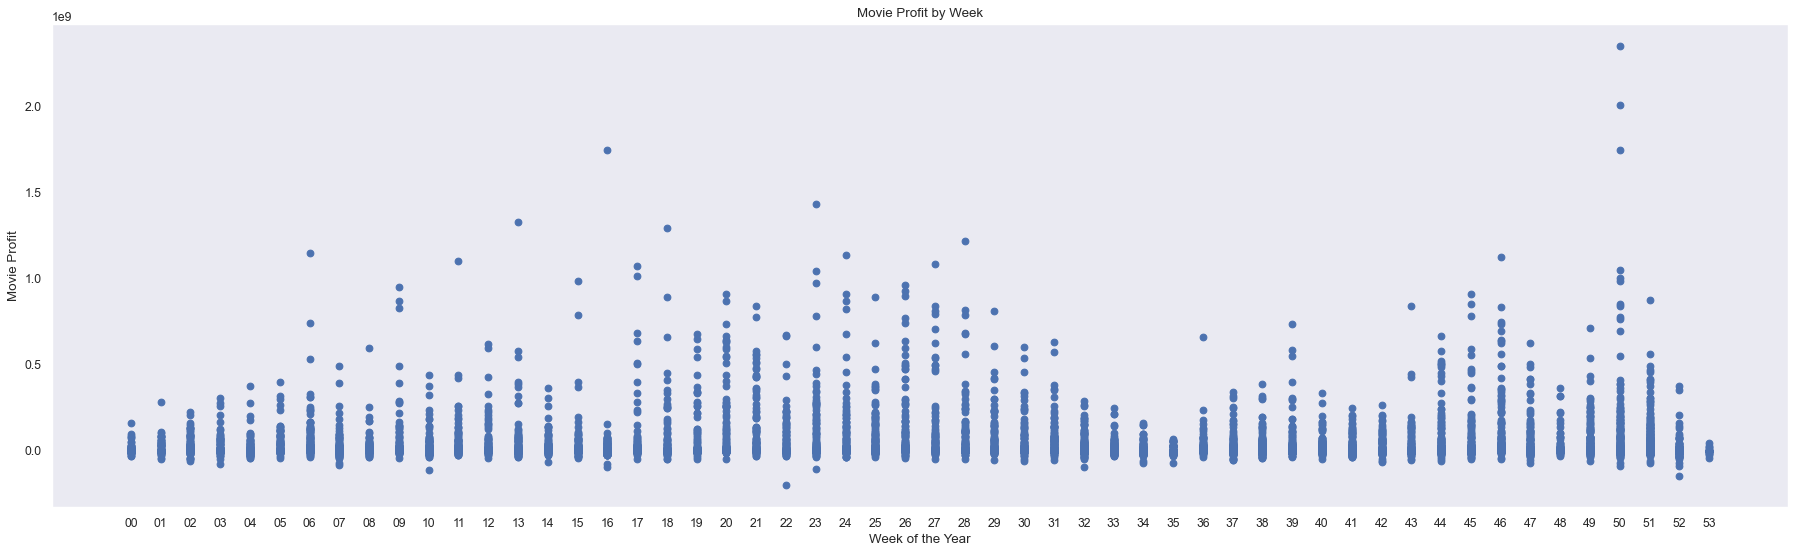

In [65]:
plt.figure(figsize=(28, 8), dpi=80)

movie_realease_by_week = plt.scatter(x = tnmovie['release_week'], y = tnmovie['profit'])

plt.grid(False)
plt.title('Movie Profit by Week')
plt.xlabel('Week of the Year')
plt.ylabel('Movie Profit')
plt.show();

Thoughts for tomorrow. Christmas 51, Thanksgiving 46, Chinese New Year 06, Late Spring 20.<br>
 Maybe could average the values for each week to make it more simple and readable.

### Import PANDASQL

In [66]:
pysqldf = lambda q: sqldf(q, globals())

### Creation of Average Profit Weekly Column

In [67]:
q = '''SELECT release_week,
            AVG(profit) as Average_Profit_Weekly
       FROM tnmovie
       GROUP BY
           release_week;'''
tnmovies_pandas_weekly = pysqldf(q)
tnmovies_pandas_weekly

,release_week,Average_Profit_Weekly
0,00,1.311402e+07
1,01,2.283090e+07
2,02,2.988502e+07
3,03,3.245423e+07
4,04,1.914611e+07
5,05,4.449597e+07
6,06,7.565514e+07
7,07,3.091450e+07
8,08,2.520160e+07
9,09,6.997169e+07


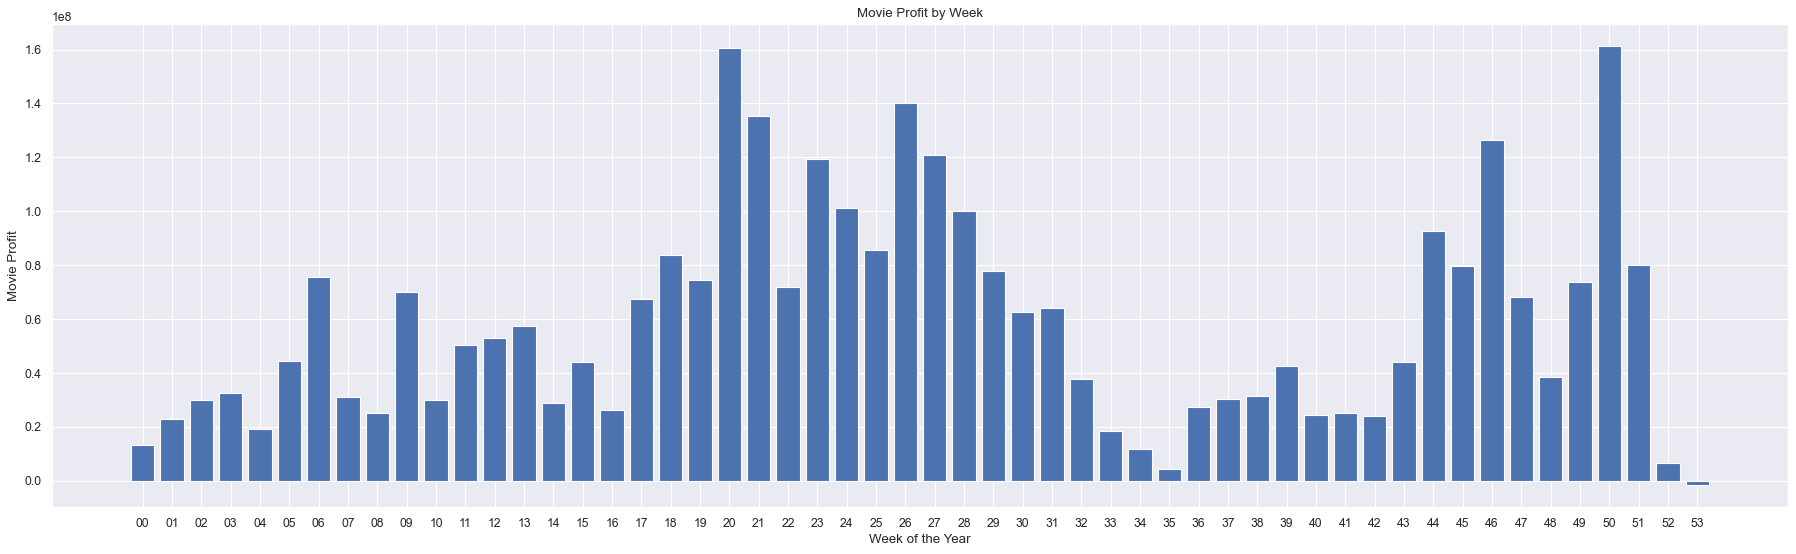

In [68]:
plt.figure(figsize=(28, 8), dpi=80)
movie_realease_by_week = plt.bar(x = tnmovies_pandas_weekly['release_week'], height = tnmovies_pandas_weekly['Average_Profit_Weekly'])
plt.title('Movie Profit by Week')
plt.xlabel('Week of the Year')
plt.ylabel('Movie Profit')
plt.show();

Maybe this visual would be easier read if it only contained months?

### Monthly data filtered by last 10 years

In [69]:
q5 = '''SELECT release_month,
            AVG(profit) as Average_Profit_Monthly,
            ROUND(AVG(profit)/1000000, 2) AS Graph_APM
       FROM tnmovie
       WHERE
           release_year > 2008
       GROUP BY
           release_month;'''
tnmovies_pandas_monthly_10_years = pysqldf(q5)
tnmovies_pandas_monthly_10_years

,release_month,Average_Profit_Monthly,Graph_APM
0,01,4.105338e+07,41.05
1,02,6.218702e+07,62.19
2,03,6.793419e+07,67.93
3,04,5.852027e+07,58.52
4,05,1.257280e+08,125.73
5,06,1.197938e+08,119.79
6,07,1.241882e+08,124.19
7,08,4.719981e+07,47.20
8,09,3.412845e+07,34.13
9,10,4.021563e+07,40.22


### Creation of Monthly Average Bar Graph

In [70]:
month_mapping = {
    '01': "January",
    '02': "February",
    '03': "March",
    '04': "April",
    '05': "May",
    '06': "June",
    '07': "July",
    '08': "August",
    '09': "September",
    '10': "October",
    '11': "November",
    '12': "December"
}

In [71]:
tnmovies_pandas_monthly_10_years['Month Title'] = tnmovies_pandas_monthly_10_years['release_month'].map(month_mapping)

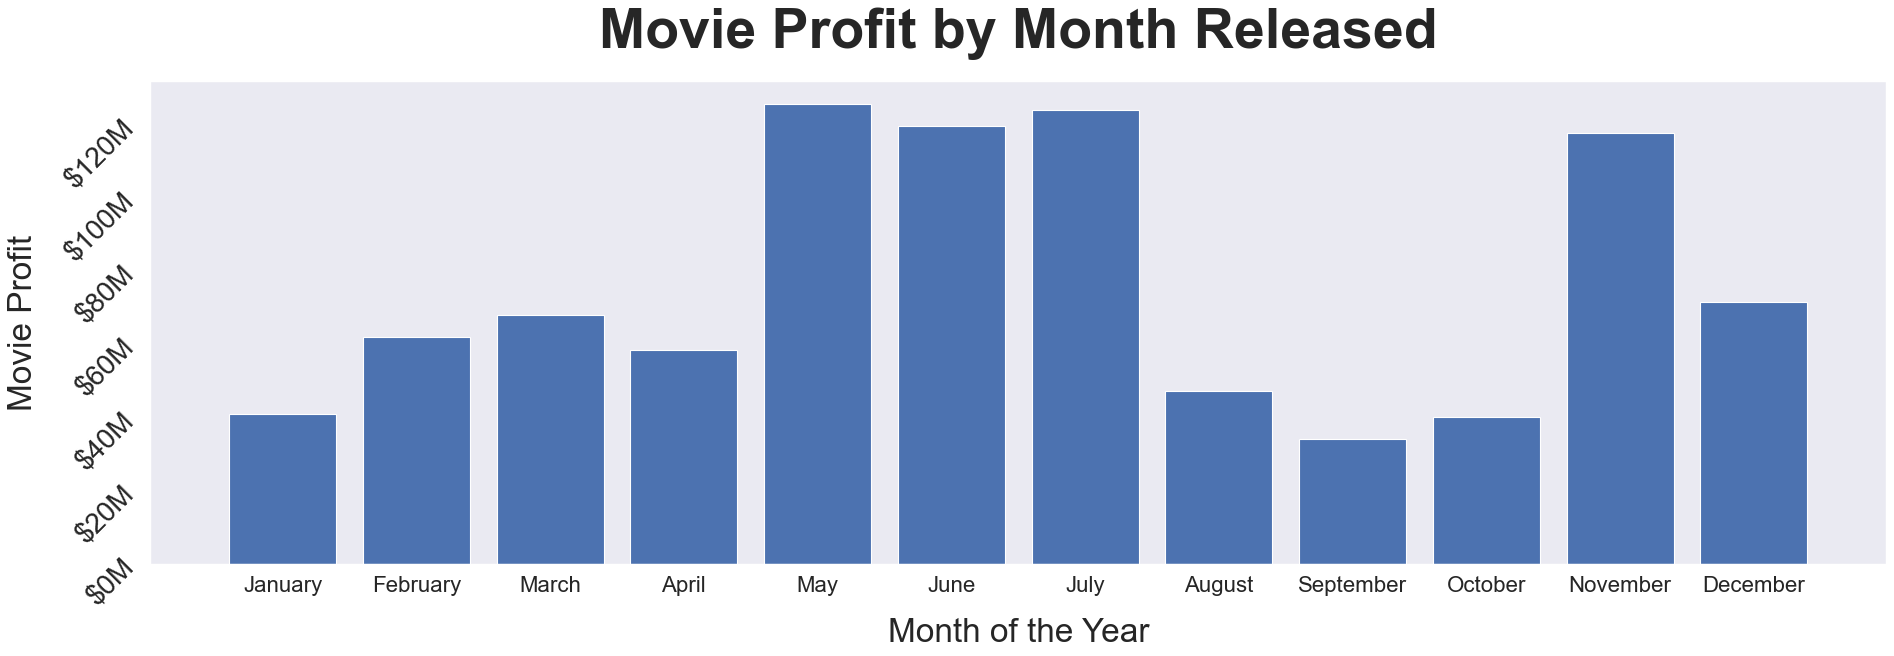

In [72]:
plt.figure(figsize=(28, 8), dpi=80)
movie_realease_by_month_10_year = plt.bar(x = tnmovies_pandas_monthly_10_years['Month Title'], height = tnmovies_pandas_monthly_10_years['Graph_APM'])


plt.title('Movie Profit by Month Released', fontsize = 50, fontweight='bold', pad = 30)
plt.xlabel('Month of the Year', fontsize = 30, labelpad = 20)
plt.ylabel('Movie Profit', fontsize = 30, labelpad = 20)

plt.ticklabel_format(axis='y', style='plain')
plt.ticklabel_format(axis='x')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 25, rotation = 45)
plt.grid(False)

#tick unit edit
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%dM'))

#plt.savefig('finalpbm2.jpeg', dpi=120)
plt.show();

This graph is okay but starts to eliminate important data. December has the overall best release date of Christmas but then is immediately followed by the worst release days leading up to New Year and when you combine the two it hides these insights.

### Filtering to See Trends in the Last 10 Years

### Weekly data filtered by last 10 years

In [73]:
q4 = '''SELECT release_week,
            AVG(profit) as Average_Profit_Weekly,
            ROUND(AVG(profit)/1000000, 2) AS Graph_APM
       FROM tnmovie
       WHERE
            release_year > 2008       
       GROUP BY
           release_week;'''
tnmovies_pandas_weekly_10_years = pysqldf(q4)
tnmovies_pandas_weekly_10_years

,release_week,Average_Profit_Weekly,Graph_APM
0,00,3.867995e+07,38.68
1,01,3.329541e+07,33.30
2,02,4.546626e+07,45.47
3,03,4.287205e+07,42.87
4,04,3.371369e+07,33.71
5,05,4.989867e+07,49.90
6,06,1.128469e+08,112.85
7,07,6.129587e+07,61.30
8,08,1.850117e+07,18.50
9,09,1.237226e+08,123.72


### Creation of Weekly Release Profits Graph Filtered by Last 10 Years

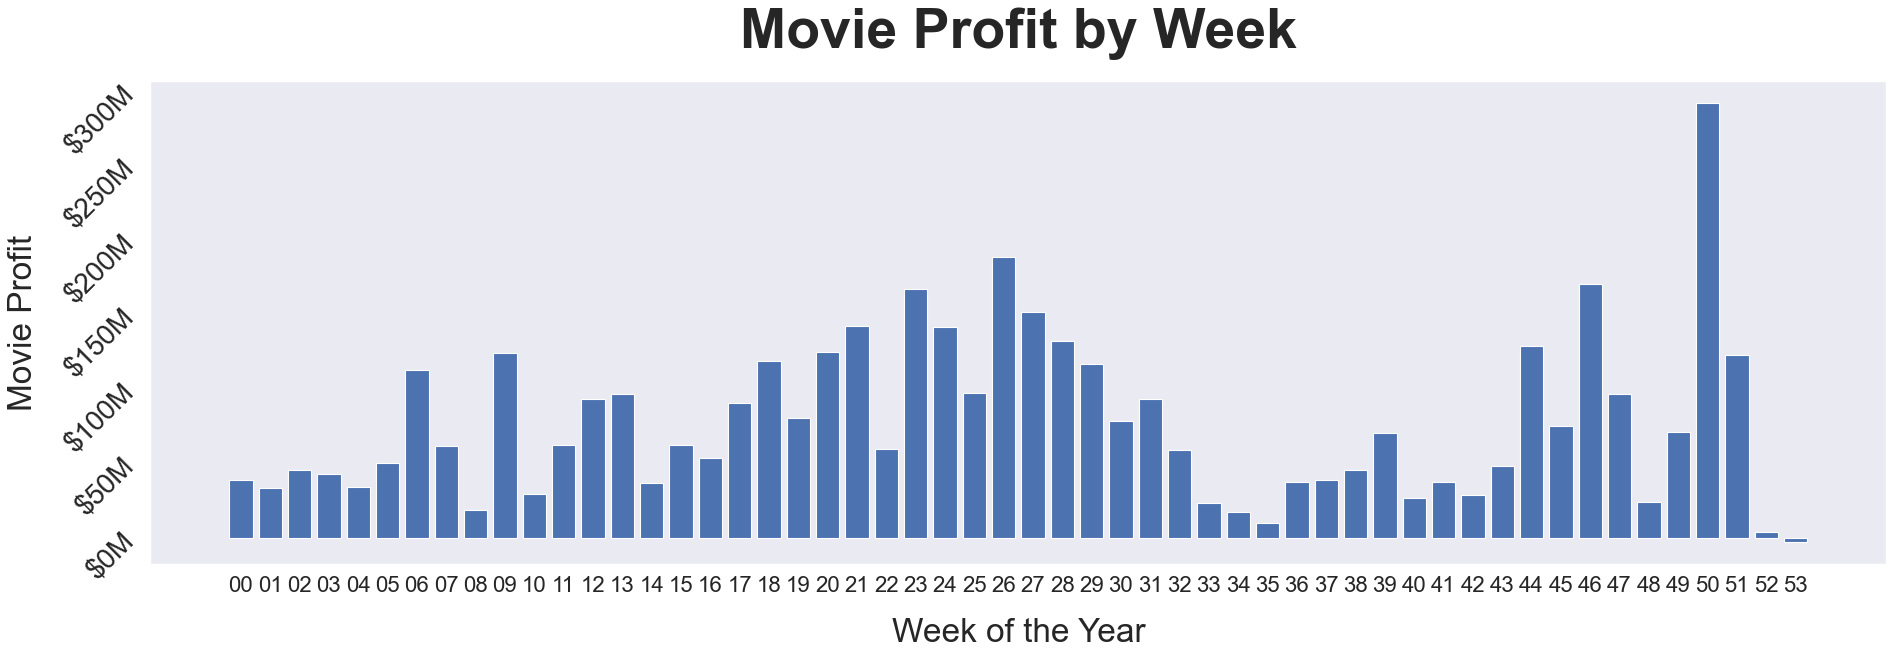

In [74]:
plt.figure(figsize=(28, 8), dpi=80)
movie_realease_by_week_10_year = plt.bar(x = tnmovies_pandas_weekly_10_years['release_week'], height = tnmovies_pandas_weekly_10_years['Graph_APM'])

#Graph Labels
plt.title('Movie Profit by Week', fontsize = 50, fontweight='bold', pad = 30)
plt.xlabel('Week of the Year', fontsize = 30, labelpad = 20)
plt.ylabel('Movie Profit', fontsize = 30, labelpad = 20)

#tick formatting
plt.ticklabel_format(axis='y', style='plain')
plt.ticklabel_format(axis='x')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 25, rotation = 45)
plt.grid(False)

#tick unit edit
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%dM'))
#Margin around plot
#plt.margins(.1, .1)

#Vertical Line
#plt.text(48.6, 178,'Christmas Day',rotation=90, color = 'black', fontsize = 20, fontweight='bold')
#plt.text(44.6, 188,'Thanksgiving',rotation=90, color = 'black', fontsize = 20, fontweight='bold')
#plt.axvline(x=26, ymin=0, ymax=1, color = 'lightcoral')
#plt.text(24.6, 185,'Memorial Day',rotation=90, color = 'black', fontsize = 20, fontweight='bold')
#plt.axvline(x=6, ymin=0, ymax=1, color = 'lightcoral')
#plt.text(4.6, 150,'Chinese New Year',rotation=90, color = 'black', fontsize = 20, fontweight='bold')

#plt.savefig('finalpbw2.jpeg', dpi=120)
plt.show();

### Findings

In November and December, people are traveling to see their family, and oftentimes deciding to go see a movie together. Depending on the release date for your movie, you can see a huge success, or a huge flop, even with great star power.

### Reviewing Critic Rating Data Against Profit/ROI

In [75]:
rt_reviews_df = pd.read_csv('./Data/rt.reviews.tsv',
                           delimiter='\t',
                           encoding=('unicode_escape'))

In [76]:
bom = pd.read_csv('./Data/bom.movie_gross.csv')

In [77]:
rt_movie_info = pd.read_csv('./Data/rt.movie_info.tsv',
                           delimiter = '\t')

# List of SQL Tables

## Viewing Table Heads to Locate Relevant Columns

### Rotten Tomatoes Reviews

In [78]:
rt_reviews_df.head(2)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"


In [79]:
rt_reviews_df.shape

(54432, 8)

Things to notice here are that the id is obviously an ID they use for the movie title. Date is not the release date of the movie rather the date of the review.

### Rotten Tomatoes Movie Info

In [80]:
rt_movie_info.head(2)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


In [81]:
rt_movie_info.shape

(1560, 12)

It seems that because this database does not include the title of the films that, even though it has a lot of review data, it is unusable for our purposes.

### Box Office Mojo

In [82]:
bom.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


Does not contain any review data.

### The Numbers

In [83]:
tnmovie.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,perc_return,release_date_month,release_week,release_month,release_year
5455,56,1991-01-01,Johnny Suede,500000,55000,55000,-445000,-89.000000,01/01,00,01,1991
5527,28,1980-01-01,Maniac,350000,10000000,10000000,9650000,2757.142857,01/01,00,01,1980


Tnmovie does not contain any review data.

### IMDB

#### Movie Ratings

In [84]:
pd.read_sql('''
SELECT
    *
FROM
    movie_ratings

''',conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


This looks promising, will have to join on movie ID to make useable DF.

#### Movie Basics

In [85]:
cleaned_movie_basics = pd.read_sql('''
SELECT
    *
FROM
    movie_basics
WHERE
    movie_id IN (SELECT movie_id
                 FROM movie_ratings
                 WHERE numvotes > 700)

''',conn)

## Joining Movie Basics and Movie Ratings

In [86]:
pd.read_sql('''
SELECT
    *
FROM
    movie_basics
JOIN movie_ratings
USING (movie_id)
WHERE
    movie_id IN (SELECT movie_id
                 FROM movie_ratings
                 WHERE numvotes > 700)
''',conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
1,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248
2,tt0293069,Dark Blood,Dark Blood,2012,86.0,Thriller,6.6,1053
3,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378
4,tt0323808,The Wicker Tree,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328
...,...,...,...,...,...,...,...,...
11625,tt9573980,Leaving Neverland,Leaving Neverland,2019,240.0,Documentary,7.1,19632
11626,tt9597190,Pegasus,Fei chi ren sheng,2019,98.0,"Comedy,Sport",6.4,817
11627,tt9778170,Panodrama,Panodrama,2019,64.0,Documentary,3.1,2220
11628,tt9815714,The Hard Way,The Hard Way,2019,92.0,Action,4.7,1214


In [87]:
review_id_df = pd.read_sql('''
SELECT
    *
FROM
    movie_basics
JOIN movie_ratings
USING (movie_id)
WHERE
    movie_id IN (SELECT movie_id
                 FROM movie_ratings
                 WHERE numvotes > 700)
''',conn)

## Creating Scatter Plot for Numvotes vs AverageRating

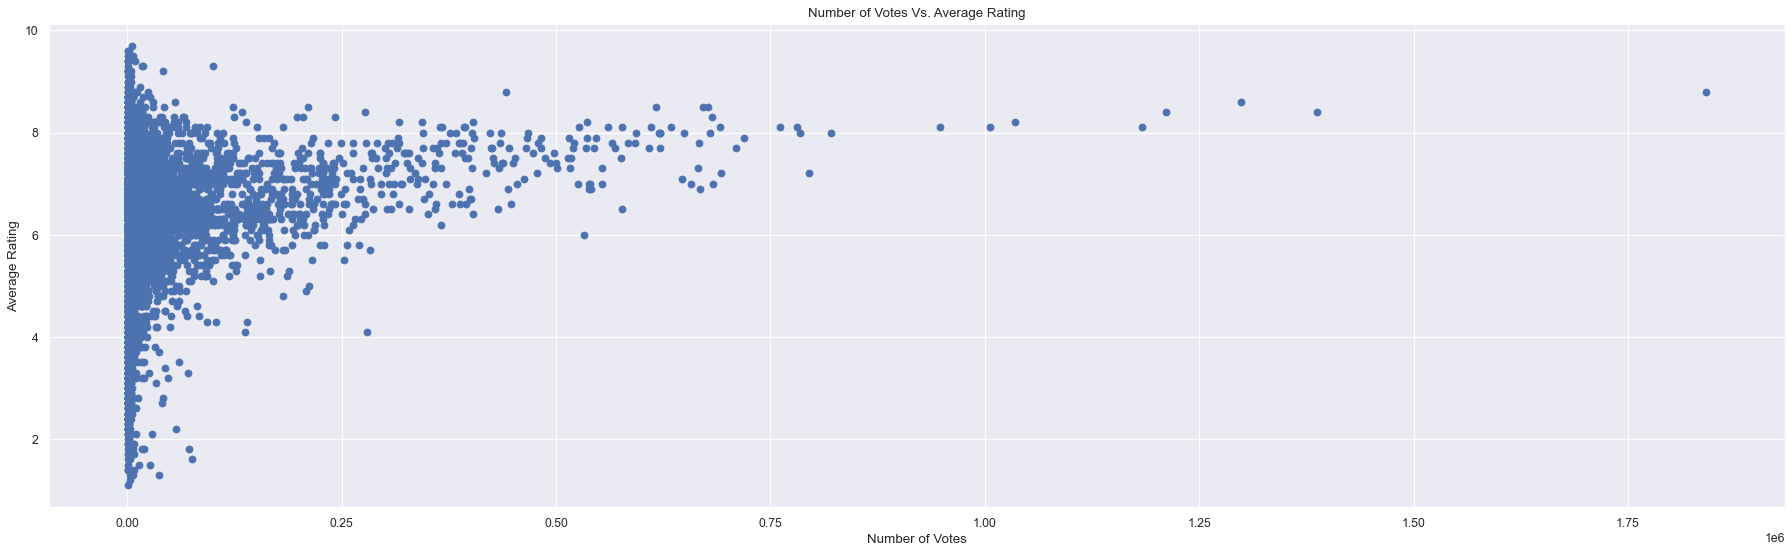

In [88]:
plt.figure(figsize=(28, 8), dpi=80)
rating_vs_num_reviews = plt.scatter(x = review_id_df['numvotes'], y = review_id_df['averagerating'])
plt.title('Number of Votes Vs. Average Rating')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.show();

It seems like the metrics of number of reviews vs average rating isnt going to be all that important to the big wigs. I should probably add profit to this!

It will be important to when combining DF's that we try and preserve as many of these rows as possible.

# Create Simple The Numbers DF

In [89]:
q = '''SELECT 
            movie,
            profit,
            perc_return
       FROM tnmovie
       ORDER BY
           profit DESC;'''
tnmovies_title_profit = pysqldf(q)
tnmovies_title_profit

,movie,profit,perc_return
0,Avatar,2351345279,553.257713
1,Titanic,2008208395,1004.104198
2,Avengers: Infinity War,1748134200,582.711400
3,Star Wars Ep. VII: The Force Awakens,1747311220,571.016739
4,Jurassic World,1433854864,666.909239
...,...,...,...
5777,Town & Country,-94635231,-90.128791
5778,Men in Black: International,-106900000,-97.181818
5779,Mars Needs Moms,-110450242,-73.633495
5780,Moonfall,-150000000,-100.000000


In [90]:
review_id_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
1,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248
2,tt0293069,Dark Blood,Dark Blood,2012,86.0,Thriller,6.6,1053
3,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378
4,tt0323808,The Wicker Tree,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328


# Attempt One to Join The Numbers and IMDB

In [91]:
tn_imdb_profit = pd.merge(tnmovies_title_profit,
                  review_id_df,
                  left_on='movie',
                  right_on='primary_title',
                  )

In [92]:
tn_imdb_profit = tn_imdb_profit.drop_duplicates(subset = 'movie')

# Creation of NumReviews VS Profit Scatter

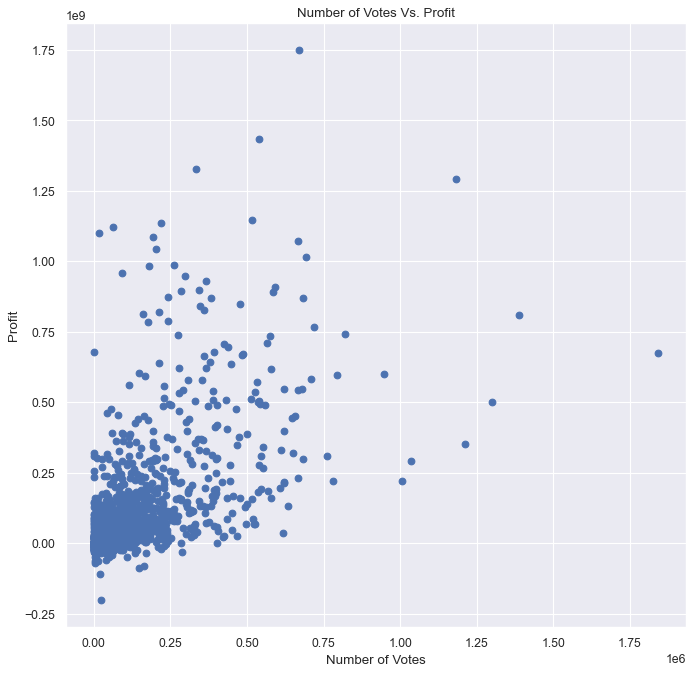

In [93]:
plt.figure(figsize=(10, 10), dpi=80)
numreviews_vs_profit = plt.scatter(x = tn_imdb_profit['numvotes'], y = tn_imdb_profit['profit'])
plt.title('Number of Votes Vs. Profit')
plt.xlabel('Number of Votes')
plt.ylabel('Profit')
plt.show();

In [94]:
tn_imdb_profit.head(25)

,movie,profit,perc_return,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,Avengers: Infinity War,1748134200,582.711400,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926
1,Jurassic World,1433854864,666.909239,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338
2,Furious 7,1328722794,699.327786,tt2820852,Furious 7,Furious Seven,2015,137.0,"Action,Crime,Thriller",7.2,335074
3,The Avengers,1292935897,574.638176,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655
5,Black Panther,1148258224,574.129112,tt1825683,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148
6,Jurassic World: Fallen Kingdom,1135772799,668.101646,tt4881806,Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,2018,128.0,"Action,Adventure,Sci-Fi",6.2,219125
7,Frozen,1122469910,748.313273,tt1323045,Frozen,Frozen,2010,93.0,"Adventure,Drama,Sport",6.2,62311
9,Beauty and the Beast,1099199706,686.999816,tt2316801,Beauty and the Beast,La belle et la bête,2014,112.0,"Drama,Fantasy,Romance",6.4,18100
13,Minions,1086336173,1468.021855,tt2293640,Minions,Minions,2015,91.0,"Adventure,Animation,Comedy",6.4,193917
14,Avengers: Age of Ultron,1072413963,324.384139,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",7.3,665594


# Creation of Rating VS Profit

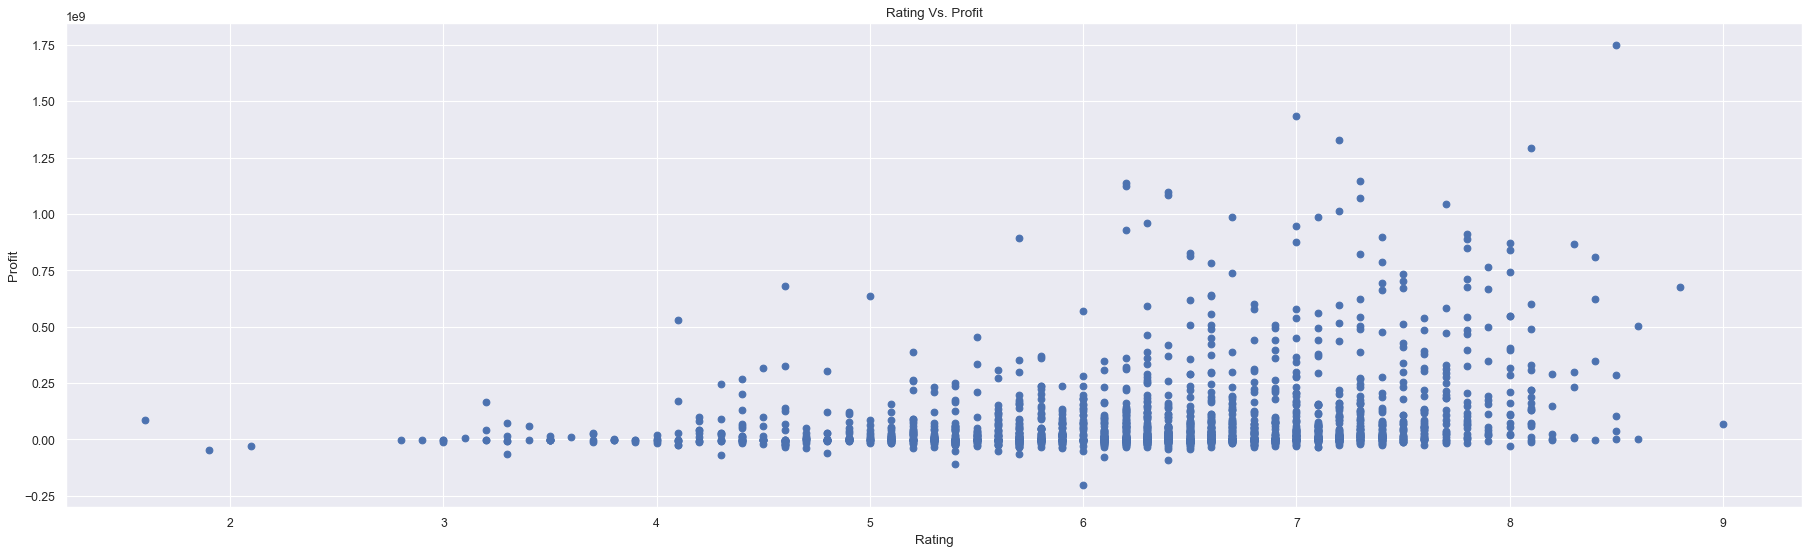

In [95]:
plt.figure(figsize=(28, 8), dpi=80)
numreviews_vs_profit = plt.scatter(x = tn_imdb_profit['averagerating'], y = tn_imdb_profit['profit'])
plt.title('Rating Vs. Profit')
plt.xlabel('Rating')
plt.ylabel('Profit')
plt.show();

# Creating Box and Whiskers for All Ratings Values

<AxesSubplot:xlabel='averagerating', ylabel='profit'>

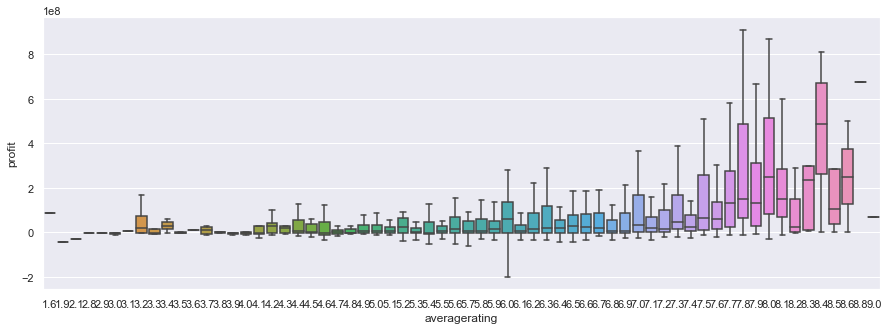

In [96]:
fig, ax1 = plt.subplots(figsize=(15,5))

# Plot distribution of column with highest correlation
sns.boxplot(
    x=tn_imdb_profit['averagerating'],
    y=tn_imdb_profit["profit"],
    showfliers = False,
    ax=ax1)

Well it's obvious I need to round these reviews out!

# Normalizing Reviews

In [97]:
tn_imdb_profit.head()

,movie,profit,perc_return,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,Avengers: Infinity War,1748134200,582.711400,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926
1,Jurassic World,1433854864,666.909239,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338
2,Furious 7,1328722794,699.327786,tt2820852,Furious 7,Furious Seven,2015,137.0,"Action,Crime,Thriller",7.2,335074
3,The Avengers,1292935897,574.638176,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655
5,Black Panther,1148258224,574.129112,tt1825683,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148


In [98]:
tn_imdb_profit['averagerating_int'] = tn_imdb_profit['averagerating'].round()

In [99]:
tn_imdb_profit.head()

,movie,profit,perc_return,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,averagerating_int
0,Avengers: Infinity War,1748134200,582.711400,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926,8.0
1,Jurassic World,1433854864,666.909239,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,7.0
2,Furious 7,1328722794,699.327786,tt2820852,Furious 7,Furious Seven,2015,137.0,"Action,Crime,Thriller",7.2,335074,7.0
3,The Avengers,1292935897,574.638176,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655,8.0
5,Black Panther,1148258224,574.129112,tt1825683,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148,7.0


In [100]:
tn_imdb_profit['averagerating_int'] = tn_imdb_profit['averagerating'].round()

In [101]:
tn_imdb_profit.value_counts('averagerating_int')

averagerating_int
6.0    653
7.0    557
5.0    219
8.0    186
4.0     83
3.0     17
9.0      4
2.0      3
dtype: int64

# Removing Outliers ROI out of bounds

In [102]:
q3 = '''SELECT *
       FROM tn_imdb_profit
        ORDER BY
            perc_return DESC; '''
mean_per_rating_todrop = pysqldf(q3)
mean_per_rating_todrop

,movie,profit,perc_return,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,averagerating_int
0,The Gallows,41556474,41556.474000,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller",4.2,17763,4.0
1,The Devil Inside,100759490,10075.949000,tt1560985,The Devil Inside,The Devil Inside,2012,83.0,Horror,4.2,33522,4.0
2,The Birth of a Nation,10890000,9900.000000,tt4196450,The Birth of a Nation,The Birth of a Nation,2016,120.0,"Biography,Drama,History",6.4,18442,6.0
3,Insidious,98370886,6558.059067,tt1591095,Insidious,Insidious,2010,103.0,"Horror,Mystery,Thriller",6.9,254197,7.0
4,Unfriended,63364198,6336.419800,tt3713166,Unfriended,Unfriended,2014,83.0,"Horror,Mystery,Thriller",5.6,62043,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1717,The Adventurer: The Curse of the Midas Box,-25000000,-100.000000,tt1376213,The Adventurer: The Curse of the Midas Box,The Adventurer: The Curse of the Midas Box,2013,100.0,"Adventure,Family,Fantasy",5.4,5257,5.0
1718,Reagan,-25000000,-100.000000,tt1822382,Reagan,Reagan,2011,105.0,"Biography,Documentary",7.4,732,7.0
1719,The Face of an Angel,-26000000,-100.000000,tt2967008,The Face of an Angel,The Face of an Angel,2014,101.0,"Crime,Drama",4.6,4211,5.0
1720,The Ridiculous 6,-60000000,-100.000000,tt2479478,The Ridiculous 6,The Ridiculous 6,2015,119.0,"Comedy,Western",4.8,38694,5.0


In [103]:
mean_clean = mean_per_rating_todrop.drop([0, 1])

In [104]:
mean_clean.shape

(1720, 12)

# Removing Justin Movie skewing Data

In [105]:
q4 = '''SELECT *
       FROM mean_clean
        ORDER BY 
        averagerating_int; '''
mean_clean_no_justin = pysqldf(q4)
mean_clean_no_justin

,movie,profit,perc_return,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,averagerating_int
0,Justin Bieber: Never Say Never,86034125,661.800962,tt1702443,Justin Bieber: Never Say Never,Justin Bieber: Never Say Never,2011,105.0,"Documentary,Music",1.6,74978,2.0
1,United Passions,-29831168,-99.437227,tt2814362,United Passions,United Passions,2014,110.0,"Drama,History,Sport",2.1,3878,2.0
2,Foodfight!,-44926294,-99.836209,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,2.0
3,Slender Man,41723644,417.236440,tt5690360,Slender Man,Slender Man,2018,93.0,"Horror,Mystery,Thriller",3.2,19650,3.0
4,The Emoji Movie,166562312,333.124624,tt4877122,The Emoji Movie,The Emoji Movie,2017,86.0,"Adventure,Animation,Comedy",3.2,47294,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1715,Icarus,-6000000,-100.000000,tt6333060,Icarus,Icarus,2017,120.0,"Documentary,Sport,Thriller",7.9,28979,8.0
1716,Inception,675524642,422.202901,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,9.0
1717,Interstellar,501379375,303.866288,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334,9.0
1718,Frankenstein,67006296,148.902880,tt1795369,Frankenstein,National Theatre Live: Frankenstein,2011,130.0,Drama,9.0,1832,9.0


In [106]:
mean_clean_sans_justin = mean_clean_no_justin.drop([0])

In [107]:
mean_clean_sans_justin

,movie,profit,perc_return,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,averagerating_int
1,United Passions,-29831168,-99.437227,tt2814362,United Passions,United Passions,2014,110.0,"Drama,History,Sport",2.1,3878,2.0
2,Foodfight!,-44926294,-99.836209,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,2.0
3,Slender Man,41723644,417.236440,tt5690360,Slender Man,Slender Man,2018,93.0,"Horror,Mystery,Thriller",3.2,19650,3.0
4,The Emoji Movie,166562312,333.124624,tt4877122,The Emoji Movie,The Emoji Movie,2017,86.0,"Adventure,Animation,Comedy",3.2,47294,3.0
5,Vampires Suck,61424988,307.124940,tt1666186,Vampires Suck,Vampires Suck,2010,82.0,Comedy,3.4,43984,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1715,Icarus,-6000000,-100.000000,tt6333060,Icarus,Icarus,2017,120.0,"Documentary,Sport,Thriller",7.9,28979,8.0
1716,Inception,675524642,422.202901,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,9.0
1717,Interstellar,501379375,303.866288,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334,9.0
1718,Frankenstein,67006296,148.902880,tt1795369,Frankenstein,National Theatre Live: Frankenstein,2011,130.0,Drama,9.0,1832,9.0


# Creating Box and Whiskers and Line Graph

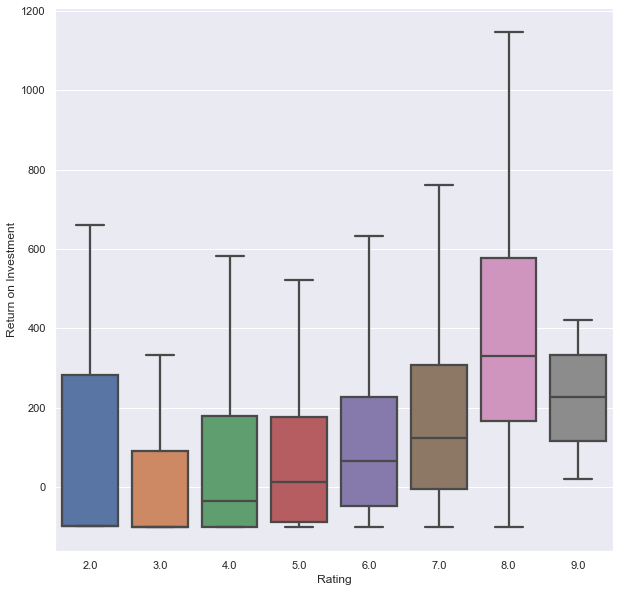

In [108]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.set_style("white")
sns.set_context("talk")

# Plot distribution of column with highest correlation
sns.boxplot(
    x=tn_imdb_profit['averagerating_int'],
    y=tn_imdb_profit["perc_return"],
    showfliers = False,
    ax=ax1)
ax1.set(xlabel='Rating', ylabel='Return on Investment')
plt.show();

# Creation of ROI by Rating Line

In [109]:
import matplotlib.ticker as mtick

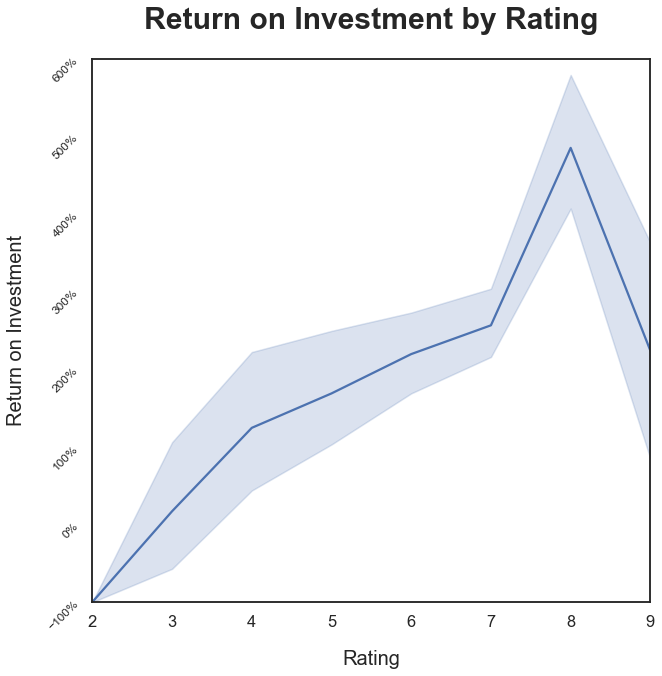

In [110]:
fig, ax2 = plt.subplots(figsize=(10,10))
sns.lineplot(data=mean_clean_sans_justin, x='averagerating_int', y="perc_return", ax=ax2)

#Figure titles
plt.title('Return on Investment by Rating', fontsize = 30, fontweight='bold', pad = 30)
plt.xlabel('Rating', fontsize = 20, labelpad = 20)
plt.ylabel('Return on Investment', fontsize = 20, labelpad = 20)

#Setting the limits of the Graph
ax2.set_xlim(2, 9)
ax2.set_ylim(-100, 600)

#Messing with the ticks
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(symbol='%'))
plt.yticks(rotation = 45, fontsize = 12)

#plt.savefig('ROI.jpeg', dpi=120)
plt.show();

# Simple Df to create Simple Graph ROI vs. Rating

In [111]:
mean_clean.value_counts('averagerating_int')

averagerating_int
6.0    653
7.0    557
5.0    219
8.0    186
4.0     81
3.0     17
9.0      4
2.0      3
dtype: int64

In [112]:
q2 = '''SELECT 
            AVG(perc_return) AS avg_roi,
            averagerating_int AS Rating_Int
       FROM mean_clean_sans_justin
       GROUP BY
           averagerating_int
       ORDER BY
           averagerating_int; '''
mean_per_rating = pysqldf(q2)
mean_per_rating

,avg_roi,Rating_Int
0,-99.636718,2.0
1,17.252833,3.0
2,124.668370,4.0
3,168.981238,5.0
4,219.636980,6.0
5,256.678631,7.0
6,485.167271,8.0
7,223.988880,9.0


In [113]:
mean_per_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   avg_roi     8 non-null      float64
 1   Rating_Int  8 non-null      float64
dtypes: float64(2)
memory usage: 256.0 bytes


In [114]:
corr = mean_per_rating.corr()

corr.head()

,avg_roi,Rating_Int
avg_roi,1.000000,0.850194
Rating_Int,0.850194,1.000000


# Creation of Simple Graph

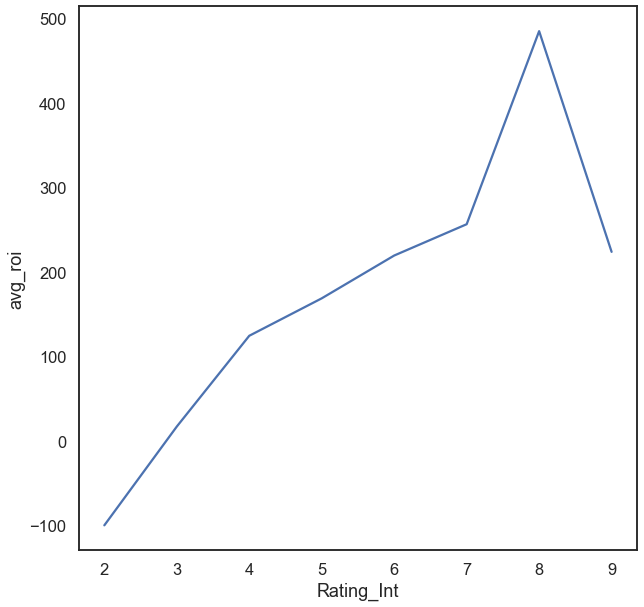

In [115]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.lineplot(data = mean_per_rating, x='Rating_Int', y='avg_roi');

### Findings

It would appear from these graphs that movies that sit around an 8 on the ratings tend to be a good return on investment as indicated by a strong positive correlation between rating and ROI. You would assume that making the best rated movie would net you the most money but that does not appear to be the case. One thing that may explain this is that viewers would prefer to see a fun and exciting movie not a critically acclaimed one.

# Results/Recommendations

With ROI/Profit as our guiding metric, Microsoft Studios may want to consider making a movie in the musical, biopic, or romance genre directed by Ridley Scott, starred by Dwayne "The Rock" Johnson, for release in early summer (May, June, July) or early winter (November, December). 

If reviews start coming in with an average rating sitting near 8/10, then the studio can have some confidence their movie's characteristics are leading to a strong ROI film.